In [1]:
import sys
import os

from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    norm = A/(np.sqrt(2*np.pi)*sigma)
    exp  = np.exp(-((x-mu)**2)/(2*sigma*sigma))
    return norm * exp

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
from scipy.interpolate import CubicSpline
import awkward
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d

date and time: 02062025


In [2]:
# Copied functions from ELOSS

Z = 18
A = 39.948   # g / mol
I = 188.0*(10**(-6)) # MeV
K = 0.307 # MeV * cm^2 / mol
Mmu = 105.658 # MeV for muon
Me  = 0.51 # MeV for electron
rho = 1.396 # g/cm3

def beta(gamma):
    return np.sqrt(1-(1./(gamma**2)))

def gamma(KE,mass):
    return (KE/mass)+1

beta = np.vectorize(beta)
gamma = np.vectorize(gamma)

def Wmax (KE,mass):
    g = gamma(KE,mass)
    b = beta(g)
    num = 2*Me*((b*g)**2)
    den = 1 + 2*g*Me/mass + (Me/mass)**2
    return num/den

def density(bg):
    # Constants from PDG elos muons table
    C  = -5.2146
    X0 = 0.2
    X1 = 3.0
    a  = 0.19559
    m  = 3.0
    N  = 2 * np.log(10)

    x = np.log10(bg)  # Ensure bg is a NumPy array

    # Vectorized handling of conditions
    density_value = np.where(
        x < X0,  # Condition 1: x < X0
        0.,  # Output if condition 1 is True
        np.where(
            x > X1,  # Condition 2: x > X1
            N * x + C,  # Output if condition 2 is True
            N * x + C + a * ((X1 - x) ** m)  # Output if neither condition is True
        )
    )

    return density_value
    
# KE in MeV
# x in cm
# mass in MeV
def dpdx(KE,x,mass,I=I):
    g = gamma(KE,mass)
    b = beta(g)
    epsilon = (K/2.)*(Z/A)*(x*rho/(b*b))
    A0 = (2*Me*(b*g)**2)/I
    A1 = epsilon/I
    return (1./x) * epsilon * (np.log(A0) + np.log(A1) + 0.2 - (b*b) - density(b*g))

# in MeV/cm
def dedx(KE,mass,I=I,dens=True):
    g = gamma(KE,mass)
    b = beta(g)
    F = K * (Z/A)*(1/b)**2
    wmax = Wmax(KE,mass)
    a0 = 0.5*np.log( 2*Me*(b*g)**2 * wmax / (I*I) )
    ret = a0 - b*b
    if (dens == True):
        ret -= density(b*g)/2.
    return F * ret


In [3]:
def KE_from_Range(R, mass, stepmax):
    R = np.asarray(R)  # Ensure R is a NumPy array
    KE = np.full_like(R, 0.3, dtype=np.float64)  # Initialize KE as an array
    dist = np.zeros_like(R, dtype=np.float64)  # Distance as array
    thisstep = np.full_like(R, 1e-3, dtype=np.float64)  # Step size as array

    while np.any((dist + thisstep) < R):  # Loop while at least one condition is True
        eloss = rho * dedx(KE, mass, dens=True)  # Compute dE/dx
        KE += eloss * thisstep  # Energy update
        dist += thisstep  # Distance update

        # Efficiently update step size
        mask = (thisstep < dist / 10.) & (dist / 10. < stepmax)
        thisstep[mask] = dist[mask] / 10.

    return KE  # Returns an array

MASS_M = 105.658
STEP = 0.1
PITCH = 0.3

In [4]:
# Import the table as data frame
file_path = '/Users/jimji/Software/Data_analysis/Research/Recom_code/muon_loss_data.csv'
df = pd.read_csv(file_path)
print(df.head())

# Parsing data from the table
T_values = df['T [MeV/c]'].to_numpy()
CSDA_values = df['CSDA range [g/cm2]'].to_numpy()
RR_values = CSDA_values / 1.396


   T [MeV/c]  CSDA range [g/cm2]
0       10.0              0.9833
1       14.0              1.7860
2       20.0              3.3210
3       30.0              6.5980
4       40.0             10.5800


In [6]:
variables = ['run','evt','ntrack','longest','reco_nu_vtx_sce_x','reco_nu_vtx_sce_y',\
             'reco_nu_vtx_sce_z','trk_sce_start_x','trk_sce_start_y','trk_sce_start_z',\
            'trk_sce_end_x','trk_sce_end_y','trk_sce_end_z','trk_llr_pid_score',\
            'trk_llr_pid_u','trk_llr_pid_v','trk_llr_pid_y',\
            'dqdx_u','dqdx_v','dqdx_y','dedx_u','dedx_v','dedx_y',\
            'rr_u','rr_v','rr_y','pitch_u','pitch_v','pitch_y']

DATA = uproot.open('/Users/jimji/Software/Data_analysis/Research/Recom_code/data_bnb_mcc9.1_v08_00_00_25_reco2_C1_beam_good_reco2_5e19.root')['nuselection']['CalorimetryAnalyzer']
DF_DATA = DATA.arrays(variables, library="pd", how="zip")

In [7]:
# select only muons
DF_MUONS = DF_DATA.query('trk_llr_pid_score > 0. and longest==1 and ntrack>1 and (trk_sce_end_x > 10 and trk_sce_end_x < 240) and (trk_sce_end_y > -100 and trk_sce_end_y < 100) and (trk_sce_end_z > 30 and trk_sce_end_z < 1000)')
rr_y_v_Muons = np.array([])
dqdx_y_v_Muons = np.array([])
pid_score_M = np.array([])

for index,entry in DF_MUONS.iterrows():
    pid_score_M = np.concatenate((pid_score_M, entry['trk_llr_pid_score']), axis=None)
    rr_y_v_Muons = np.concatenate((rr_y_v_Muons,entry['rr_y']),axis=None)
    dqdx_y_v_Muons = np.concatenate((dqdx_y_v_Muons,entry['dqdx_y']),axis=None)


print(len(rr_y_v_Muons), len(dqdx_y_v_Muons),len(pid_score_M))



1739719 1739719 6502


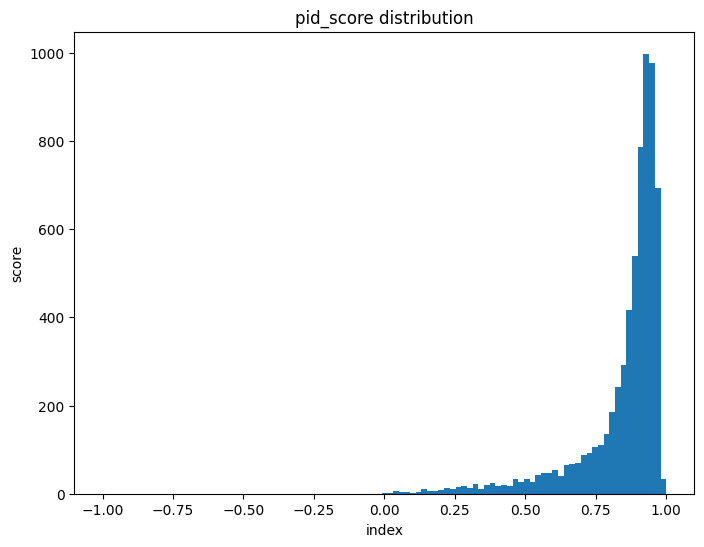

In [8]:
# Plot pid_score of Muons
fig = plt.figure(figsize=(8,6))
plt.hist(pid_score_M, bins=np.linspace(-1,1,100))
plt.title('pid_score distribution')
plt.xlabel('index')
plt.ylabel('score')
plt.show()

In [ ]:
dEdx_Muons = []


KE = KE_from_Range(rr_y_v_Muons, MASS_M, STEP)
dEdx_Muons = dedx(KE, MASS_M, I=I, dens=True) 

print(len(dEdx_Muons))

In [46]:
DF_MUONS = DF_DATA.query('trk_llr_pid_score > 0.9 and longest==1 and ntrack>1 and (trk_sce_end_x > 10 and trk_sce_end_x < 240) and (trk_sce_end_y > -100 and trk_sce_end_y < 100) and (trk_sce_end_z > 30 and trk_sce_end_z < 1000)')
rr_y_v_Muons = np.array([])
dqdx_y_v_Muons = np.array([])

for index,entry in DF_MUONS.iterrows():
    rr_y_v_Muons = np.concatenate((rr_y_v_Muons,entry['rr_y']),axis=None)
    dqdx_y_v_Muons = np.concatenate((dqdx_y_v_Muons,entry['dqdx_y']),axis=None)

print(len(rr_y_v_Muons), len(dqdx_y_v_Muons))

1473048 1473048


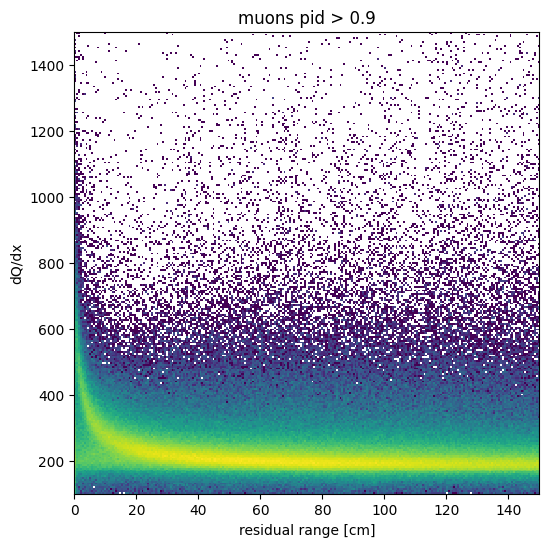

In [49]:
# Plot the curve of dQ/dx against RR for Muons
fig = plt.figure(figsize=(6,6))
BINS2D = (np.linspace(0,150,250),np.linspace(100,1500,250))
plt.hist2d(rr_y_v_Muons,dqdx_y_v_Muons,bins=BINS2D,norm=colors.LogNorm())
plt.xlabel('residual range [cm]')
plt.ylabel('dQ/dx')
plt.title('muons pid > 0.9')
plt.show()

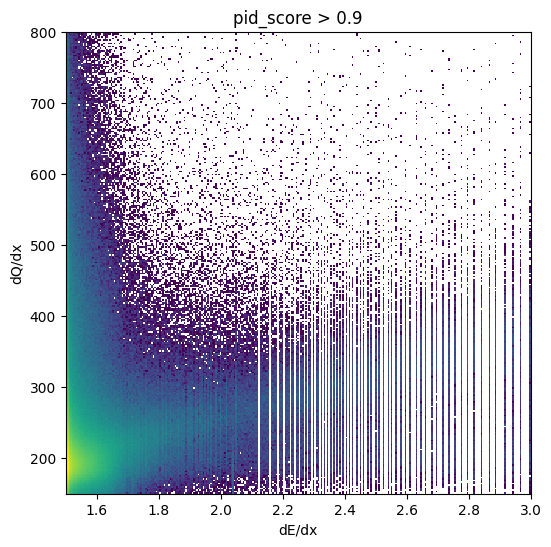

1473048


In [50]:
BINS2D = (np.linspace(1.5, 3, 300), np.linspace(150, 800, 300))
fig = plt.figure(figsize=(6,6))
plt.hist2d(dEdx_Muons, dqdx_y_v_Muons, bins=BINS2D, norm=colors.LogNorm())
plt.xlabel('dE/dx')
plt.ylabel('dQ/dx')
plt.title('pid_score > 0.9')
plt.show()

print(len(dEdx_Muons))


In [51]:
DF_MUONS = DF_DATA.query('trk_llr_pid_score > 0.95 and longest==1 and ntrack>1 and (trk_sce_end_x > 10 and trk_sce_end_x < 240) and (trk_sce_end_y > -100 and trk_sce_end_y < 100) and (trk_sce_end_z > 30 and trk_sce_end_z < 1000)')
rr_y_v_Muons = np.array([])
dqdx_y_v_Muons = np.array([])

for index,entry in DF_MUONS.iterrows():
    rr_y_v_Muons = np.concatenate((rr_y_v_Muons,entry['rr_y']),axis=None)
    dqdx_y_v_Muons = np.concatenate((dqdx_y_v_Muons,entry['dqdx_y']),axis=None)

print(len(rr_y_v_Muons), len(dqdx_y_v_Muons))

928646 928646


In [56]:
print(dqdx_y_v_Muons[:10])

[212.43069458 220.70986938 231.90789795 235.6547699  187.18843079
 220.57383728 218.99865723 204.5921936  181.9069519  240.72817993]


In [ ]:
dEdx_Muons = []


KE = KE_from_Range(rr_y_v_Muons, MASS_M, STEP)
dEdx_Muons = dedx(KE, MASS_M, I=I, dens=True) 

print(len(dEdx_Muons))

In [6]:
def KE_from_Range(R,mass,stepmax):
    KE = 0.3 # MeV
    dist = 0.
    thisstep = 1e-3        
    while ((dist+thisstep) < R):
        eloss = rho * dedx(KE,mass,dens=True)
        #print 'step: %.03f dEdx at KE %.02f is %.02f. Total dist : %.03f'%(thisstep,KE,eloss,dist)
        KE += (eloss * thisstep)
        dist += thisstep
        # update step size in an efficient way
        if ((thisstep < dist/10.) and (dist/10. < stepmax)):
            thisstep = dist/10.
    return KE

MASS_M = 105.658
STEP = 0.1
PITCH = 0.3

In [9]:
dEdx_Muons = []

for r in rr_y_v_Muons:
    KE = KE_from_Range(r, MASS_M, STEP)
    dEdx = dedx(KE, MASS_M, I=I, dens=True) 
    dEdx_Muons.append(dEdx)

print(len(dEdx_Muons))

1739719


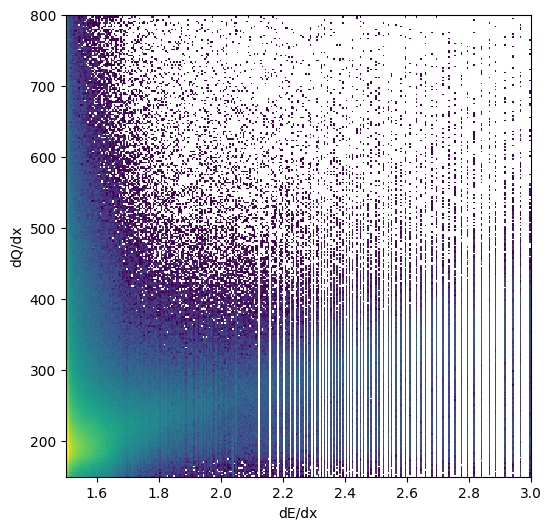

In [27]:
BINS2D = (np.linspace(1.5, 3, 300), np.linspace(150, 800, 300))
fig = plt.figure(figsize=(6,6))
plt.hist2d(dEdx_Muons, dqdx_y_v_Muons, bins=BINS2D, norm=colors.LogNorm())
plt.xlabel('dE/dx')
plt.ylabel('dQ/dx')
plt.show()

In [ ]:
# select only muons
DF_MUONS_prime = DF_DATA.query('trk_llr_pid_score > 0. and longest==1 and ntrack>1 and (trk_sce_end_x > 10 and trk_sce_end_x < 240) and (trk_sce_end_y > -100 and trk_sce_end_y < 100) and (trk_sce_end_z > 30 and trk_sce_end_z < 1000)')
rr_y_v_Muons_prime = np.array([])
dqdx_y_v_Muons_prime = np.array([])

for index,entry in DF_MUONS.iterrows():
    rr_y_v_Muons_prime = np.concatenate((rr_y_v_Muons_prime,entry['rr_y']),axis=None)
    dqdx_y_v_Muons_prime = np.concatenate((dqdx_y_v_Muons_prime,entry['dqdx_y']),axis=None)


print(len(rr_y_v_Muons_prime), len(dqdx_y_v_Muons_prime))
